## Developement of FCN Losses

In [20]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, math, io, time, gc, argparse, platform, pprint
import numpy as np
import tensorflow as tf
import keras
import keras.backend as KB
sys.path.append('../')

import mrcnn.visualize    as visualize
import mrcnn.utils        as utils

from datetime           import datetime   
from mrcnn.utils        import command_line_parser, Paths
# from mrcnn.config       import Config
# from mrcnn.dataset      import Dataset 
from mrcnn.datagen      import data_generator, load_image_gt, data_gen_simulate
from mrcnn.prep_notebook import build_fcn_training_pipeline, run_fcn_training_pipeline
from mrcnn.prep_notebook import get_prediction_batch, get_image_batch, get_training_batch
from mrcnn.coco          import prep_coco_dataset

pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)
start_time = datetime.now().strftime("%m-%d-%Y @ %H:%M:%S")
print()
print('--> Execution started at:', start_time)
print("    Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))

##------------------------------------------------------------------------------------
## Parse command line arguments
##------------------------------------------------------------------------------------
parser = command_line_parser()
input_parms  =" --batch_size 2 "
input_parms +=" --epochs 2 --steps_in_epoch 32  --last_epoch 0 --lr 0.00001 --val_steps 8 " 
input_parms +=" --mrcnn_logs_dir train_mrcnn_coco "
input_parms +=" --fcn_logs_dir   train_fcn8_coco "
input_parms +=" --mrcnn_model    last "
input_parms +=" --fcn_model      init "
input_parms +=" --opt            adam "
input_parms +=" --fcn_arch       fcn8 " 
input_parms +=" --fcn_layers     all "
input_parms +=" --coco_classes   78 79 80 81 82 44 46 47 48 49 50 51 34 35 36 37 38 39 40 41 42 43 10 11 13 14 15 "
input_parms +=" --sysout        screen "
input_parms +=" --new_log_folder    "
# input_parms +="--fcn_model /home/kbardool/models/train_fcn_adagrad/shapes20180709T1732/fcn_shapes_1167.h5"
print(input_parms)
 
parser = utils.command_line_parser()
args = parser.parse_args(input_parms.split())
utils.display_input_parms(args)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

--> Execution started at: 12-04-2018 @ 20:15:53
    Tensorflow Version: 1.8.0   Keras Version : 2.2.0 
 --batch_size 2  --epochs 2 --steps_in_epoch 32  --last_epoch 0 --lr 0.00001 --val_steps 8  --mrcnn_logs_dir train_mrcnn_coco  --fcn_logs_dir   train_fcn8_coco  --mrcnn_model    last  --fcn_model      init  --opt            adam  --fcn_arch       fcn8  --fcn_layers     all  --coco_classes   78 79 80 81 82 44 46 47 48 49 50 51 34 35 36 37 38 39 40 41 42 43 10 11 13 14 15  --sysout        screen  --new_log_folder    

Arguments passed :
--------------------
batch_size                     2
coco_classes                   [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15]
epochs                         2
fcn_arch                       FCN8
fcn_layers                     ['all']
fcn_logs_dir                   train_fcn8_coco
fcn_model           

In [21]:
mrcnn_model, fcn_model = build_fcn_training_pipeline(args = args,verbose = 1)


--> Execution started at: 12-04-2018 @ 20:15:58
    Tensorflow Version: 1.8.0   Keras Version : 2.2.0 
>>> Initialize Paths
 windows  Windows

Paths:
-------------------------
COCO_DATASET_PATH              F:\MLDatasets\coco2014
COCO_HEATMAP_PATH              F:\MLDatasets\coco2014_heatmaps
COCO_MODEL_PATH                F:\PretrainedModels\mask_rcnn_coco.h5
DIR_DATASET                    F:\MLDatasets
DIR_PRETRAINED                 F:\PretrainedModels
DIR_ROOT                       F:\
DIR_TRAINING                   F:\models
FCN_TRAINING_PATH              F:\models\train_fcn8_coco
FCN_VGG16_MODEL_PATH           F:\PretrainedModels\fcn_vgg16_weights_tf_dim_ordering_tf_kernels.h5
MRCNN_TRAINING_PATH            F:\models\train_mrcnn_coco
RESNET_MODEL_PATH              F:\PretrainedModels\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
VGG16_MODEL_PATH               F:\PretrainedModels\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


>>> Initialize ModelBase model 
   Mode     

    X/Y shapes : (256, 256) (256, 256)
    Ones:     (?, 1, 1)
    ones_exp * X (?, 1, 1) * (256, 256) =  (?, 256, 256)
    ones_exp * Y (?, 1, 1) * (256, 256) =  (?, 256, 256)
    pos_grid before transpse :  (?, 256, 256, 2)
    pos_grid after transpose :  (256, 256, ?, 2)
    >> input to MVN.PROB: pos_grid (meshgrid) shape:  (256, 256, ?, 2)
     Prob_grid shape from mvn.probe:  (256, 256, ?)
     Prob_grid shape after tanspose:  (?, 256, 256)
    << output probabilities shape  :  (?, 256, 256)
    old_style_scores        : (2, 81, 100, 3) (2, 81, 100, 3)
    prob_grid_clipped :  (?, 256, 256)

    normalization ------------------------------------------------------
    normalizer     :  (?, 1, 1)
    prob_grid_cns: clipped/normed/scaled :  (?, 256, 256)
    alt_scores_1    :  (None, 3)  Keras tensor  False
    alt_scores_1(by class)       :  (2, 81, 100, 3)  Keras tensor  False

       Normalize_scores() ------------------------------------------------------
         input shape    

    FCN Block 53                   :  shape: (?, 16, 16, 512)      KB.shape:(None, 16, 16, 512)   Keras Tensor: True
    FCN Block 54 (Max pooling)     :  shape: (?, 8, 8, 512)        KB.shape:(None, 8, 8, 512)     Keras Tensor: True

   --- FCN32 ----------------------------
    FCN fully connected 1 (fc1)    :  shape: (?, 8, 8, 4096)       KB.shape:(None, 8, 8, 4096)    Keras Tensor: True
    FCN fully connected 2 (fc2)    :  shape: (?, 8, 8, 4096)       KB.shape:(None, 8, 8, 4096)    Keras Tensor: True
    FCN conv2d (fcn32_deconv2D)    :  shape: (?, 8, 8, 81)         KB.shape:(None, 8, 8, 81)      Keras Tensor: True

   --- FCN16 ----------------------------
    FCN scorePool4 (Conv2D(Pool4)) :  shape: (?, 16, 16, 81)       KB.shape:(None, 16, 16, 81)    Keras Tensor: True
    FCN 2x Upsampling (Deconvolution2D(fcn32_classify)):  shape: (?, ?, ?, 81)         KB.shape:(None, 18, 18, 81)    Keras Tensor: True
    FCN 2x Upsampling/Cropped (Cropped2D(score2)):  shape: (?, ?, ?, 81)   

    seq_ids                        :  shape: (?,)                  KB.shape:(None,)               Keras Tensor: False
    sscatter_ids                   :  shape: (?, 2)                KB.shape:(None, 2)             Keras Tensor: False
    fcn_scores_by_class            :  shape: (2, 81, 200, 23)      KB.shape:(2, 81, 200, 23)      Keras Tensor: False
complete
  * fcn_scores shape:  (2, 81, 200, 23)  Keras tensor  True


---------------------------------------------------
    building Loss Functions 
---------------------------------------------------

-------------------------------
>>> fcn_heatmap_MSE_loss_graph 
-------------------------------
    target_masks : (?, 256, 256, 81) (None, 256, 256, 81) KerasTensor:  True
    pred_heatmap : (?, 256, 256, 81) (None, 256, 256, 81) KerasTensor:  True
    loss         : (?, 256, 256) (None, 256, 256) KerasTensor:  False
    loss mean    : () () KerasTensor:  False
    loss final   : (1, 1) (1, 1) KerasTensor:  False

----------------------

In [3]:
# mrcnn_model.keras_model.summary()
# fcn_model.keras_model.summary()
mrcnn_model.layer_info()
fcn_model.layer_info()

 Inputs:
 -------
 index:  0    input name : input_image:0                              Type: float32           Shape: (?, 1024, 1024, 3)
 index:  1    input name : input_image_meta:0                         Type: float32           Shape: (?, ?)
 index:  2    input name : input_rpn_match:0                          Type: int32             Shape: (?, ?, 1)
 index:  3    input name : input_rpn_bbox:0                           Type: float32           Shape: (?, ?, 4)
 index:  4    input name : input_gt_class_ids:0                       Type: int32             Shape: (?, ?)
 index:  5    input name : input_gt_boxes:0                           Type: float32           Shape: (?, ?, 4)
 Outputs:
 --------
 layer:  0    output name: cntxt_layer/pred_heatmap:0                 Type: float32           Shape: (1, 256, 256, 81)
 layer:  1    output name: cntxt_layer/pred_heatmap_scores:0          Type: float32           Shape: (1, 81, 100, 23)
 layer:  2    output name: cntxt_layer_gt/gt_heatmap:0  

## Load Training Files and Display Images

    train:
     image_ids[:10]       :  [262146, 524291, 9, 393227, 393230, 131087, 393241, 393242, 131099, 393251]
     image_ids[1000:1010] :  [396150, 265080, 396157, 2951, 396172, 134032, 134033, 527250, 2963, 2964]

     image_ids[:10]       :  [360449, 557059, 262148, 393225, 229385, 131089, 98322, 262162, 458778, 360480]
     image_ids[1000:1010] :  [198550, 231325, 133025, 460705, 1955, 296871, 1960, 362409, 67502, 395182]        

    val:

In [22]:
##------------------------------------------------------------------------------------
## Build & Load Training and Validation datasets
## train  : 82081 |  train + val35k : 117266
## val    : 40137 | val35k : 35185 |  minival:  4952
## 
#   'accessory':   [27, 28, 31, 32, 33],          #   'animal':     [16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
#   'appliance':  [78, 79, 80, 81, 82],           #   'background': [0],
#   'electronic': [72, 73, 74, 75, 76, 77],       #   'food':       [52, 53, 54, 55, 56, 57, 58, 59, 60, 61],
#   'furniture':  [62, 63, 64, 65, 67, 70],       #   'indoor':     [84, 85, 86, 87, 88, 89, 90],
#   'kitchen':    [44, 46, 47, 48, 49, 50, 51],   #   'outdoor':    [10, 11, 13, 14, 15],
#   'person':     [1],                            #   'sports':     [34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
#   'vehicle':    [2, 3, 4, 5, 6, 7, 8, 9]} 
## " --coco_classes:
##    appliance : 78 79 80 81 82                  kitchen: 44 46 47 48 49 50 51 
##    sports    : 34 35 36 37 38 39 40 41 42 43   indoor : 10 11 13 14 15
# ------------------------------------------------------------------------------------
# load_class_ids = [62,63,64,65,67,70,   44,46,47,48,49,50,51,  72,73,74,75,76,77 , 82,61]
# load_class_ids = [62,63,67, 78,79,80,81,82,  72,73,74,75,76,77]

load_class_ids = args.coco_classes
dataset_train, train_generator  = prep_coco_dataset(["train", 'val35k'], mrcnn_model.config, generator = True, shuffle = False, return_coco =True, load_coco_classes=load_class_ids)
# dataset_val, val_generator      = prep_coco_dataset(['minival'], mrcnn_config, generator = True) 
class_names = dataset_train.class_names

COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_train2014.json  into memory...
Done (t=21.56s)
creating index...
index created!
 load subset of classes:  [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15]
 image dir            :  F:\MLDatasets\coco2014\train2014
 json_path_dir        :  F:\MLDatasets\coco2014\annotations/instances_train2014.json
 number of images     :  40400
 image_ids[:10]       :  [262146, 524291, 9, 393227, 393230, 131087, 393241, 393242, 131099, 393251]
 image_ids[1000:1010] :  [396150, 265080, 396157, 2951, 396172, 134032, 134033, 527250, 2963, 2964]
COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_valminusminival2014.json  into memory...
Done (t=5.42s)
creating index...
index created!
 load subset of classes:  [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15]
 image dir            :  F:\MLDatase

In [5]:
# dataset_test.display_class_info()
# pp.pprint(dataset_test.class_info)
# dataset_train.display_class_info()
# print("Training Dataset Image Count: {}".format(len(dataset_train.image_ids)))
# print("Training Dataset Class Count: {}".format(dataset_train.num_classes))

##  Get training batch and display images

In [23]:
train_batch_x, train_batch_y = next(train_generator)

D:\Program Files\Anaconda3\envs\TF\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


 Image_id    :  0  Reference:  http://cocodataset.org/#explore?id=262146 Coco Id: 262146
 Image meta [   0  640  480    3    0  128 1024  896    1    1]
 Class ids   :  (3,)    [ 1 31 25]
 Class Names :  ['person', 'skis', 'backpack']


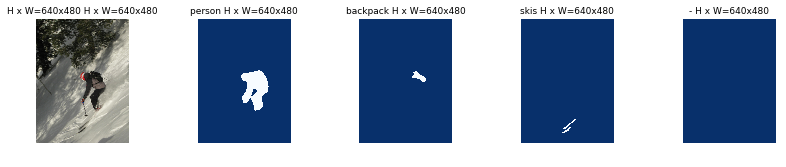

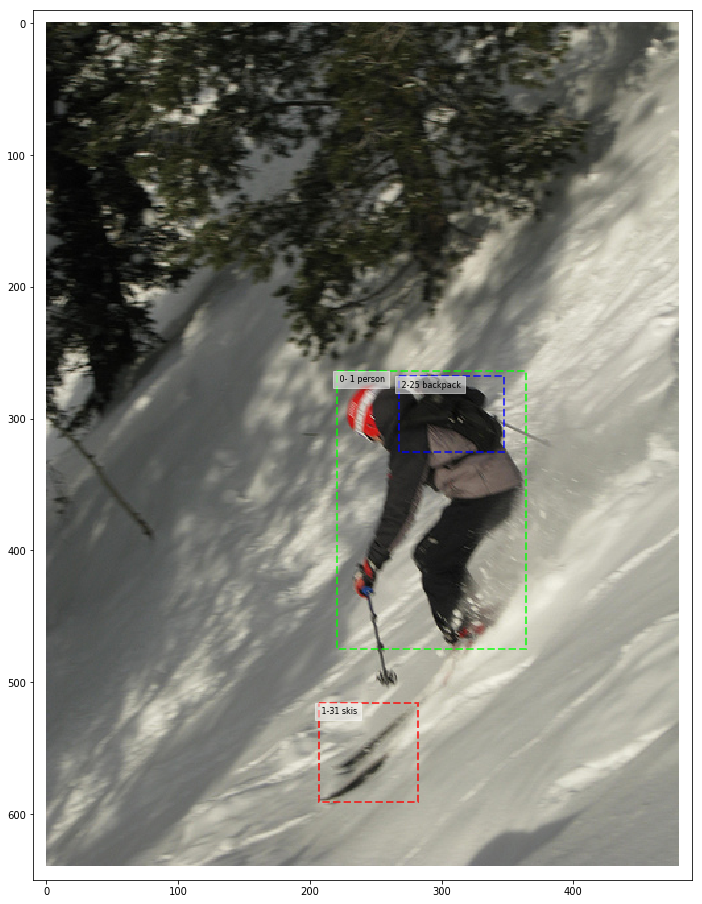

 Image_id    :  1  Reference:  http://cocodataset.org/#explore?id=524291 Coco Id: 524291
 Image meta [   1  426  640    3  171    0  853 1024    1    1]
 Class ids   :  (4,)    [17 17  1 30]
 Class Names :  ['dog', 'dog', 'person', 'frisbee']


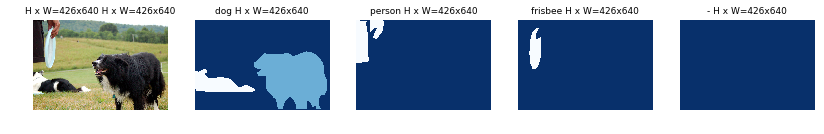

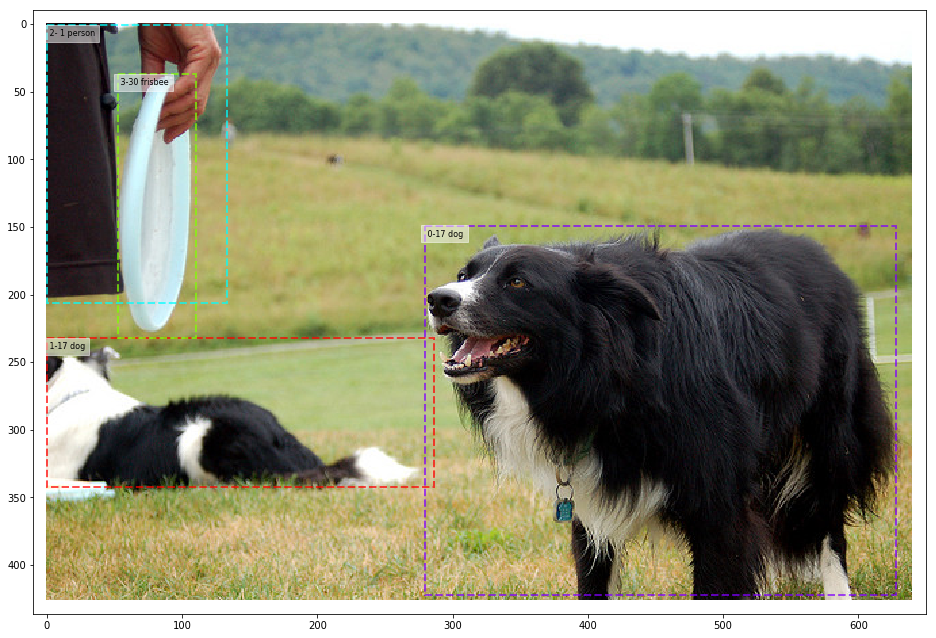

In [24]:
visualize.display_training_batch(dataset_train, train_batch_x) 

#### Load a specific image using image_id

 batch size is : 2
 load image ud:  2
 load image ud:  3
 Image_id    :  2  Reference:  http://cocodataset.org/#explore?id=9 Coco Id: 9
 Image meta [   2  480  640    3  128    0  896 1024    1    1]
 Class ids   :  (8,)    [46 46 51 46 50 50 50 50]
 Class Names :  ['bowl', 'bowl', 'broccoli', 'bowl', 'orange', 'orange', 'orange', 'orange']


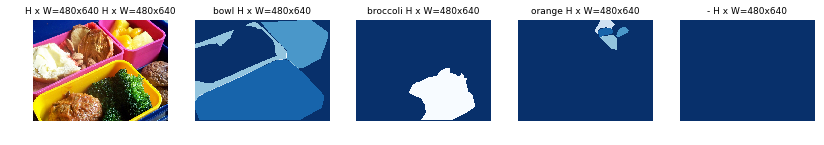

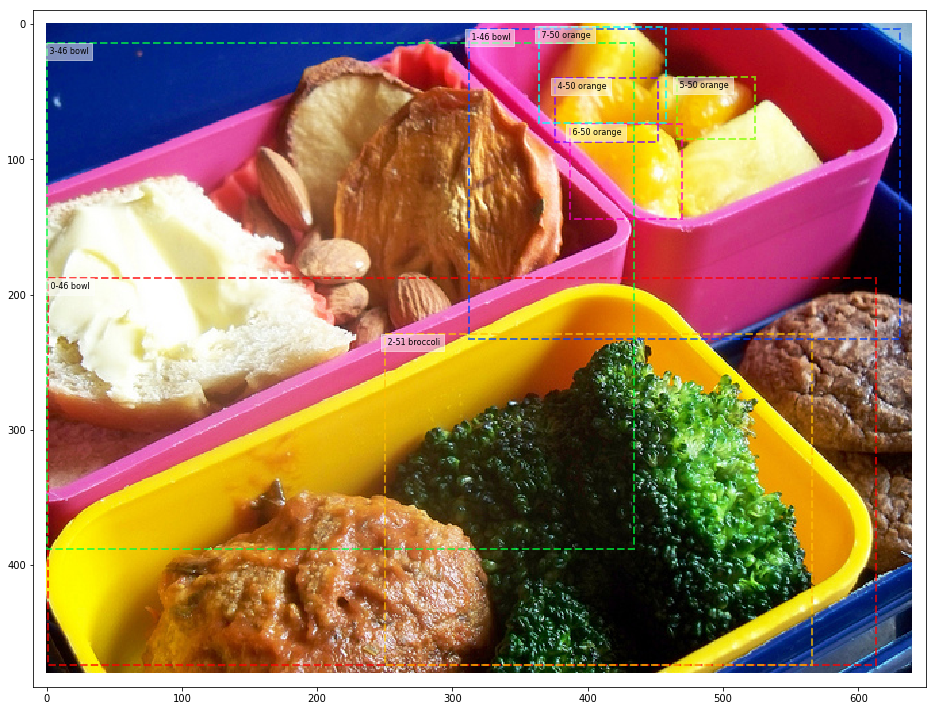

 Image_id    :  3  Reference:  http://cocodataset.org/#explore?id=393227 Coco Id: 393227
 Image meta [   3  640  427    3    0  170 1024  853    1    1]
 Class ids   :  (2,)    [ 1 37]
 Class Names :  ['person', 'skateboard']


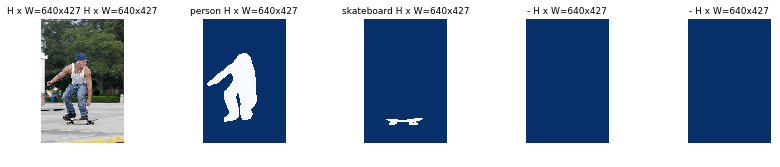

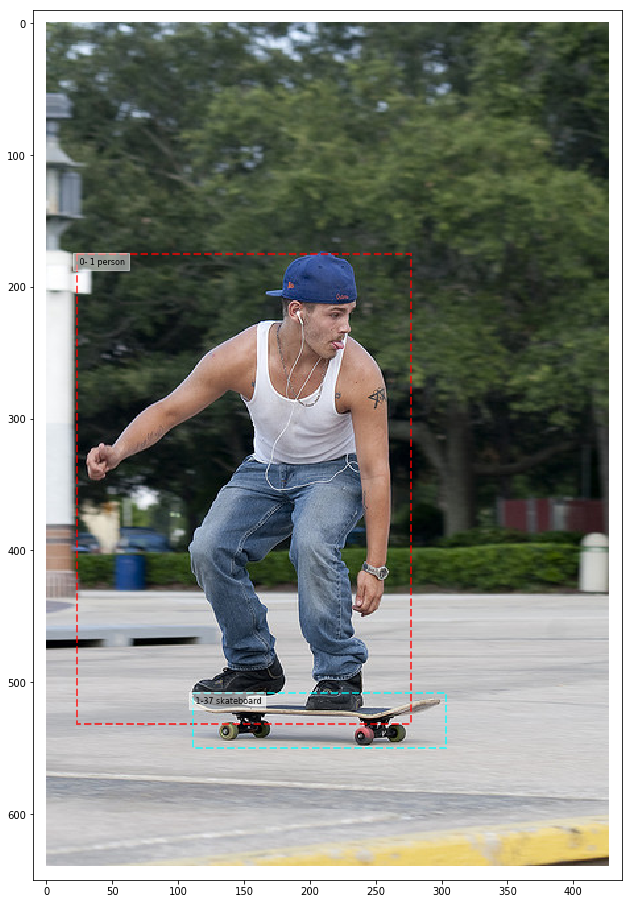

In [25]:
## 62642 (persons),   68539 (trucks) 36466 (surfers)  75040 (boat and persons)
## 36466 surfers. 5498 basketbal players, 27711,30531
## 5498 lots of motorcylces & persons - 
## Persons: #26026, #7719, 111864, 58240,  
## 35347 - laptops, keyboards and cat
## items = [59199 , 102868]
## 101623 (cake and forks), 41423 (elephant & people)
## 33477 Table, bowl, cup, sandwich, knife
## 26763 Table, chair, cup , bowl, bottle
## 49316 Table, book, backpack, many bottles
## 12902 Car , truck and traffic light tree
## 57327 person and horses
# IMAGE_LIST = [75040] 
# IMAGE_LIST = [89243]
# IMAGE_LIST = [33477]
# IMAGE_LIST = [29731]
# IMAGE_LIST = [26763]
# IMAGE_LIST = [89243]  ## 89243: Person, bicylce and traiffic lights
# IMAGE_LIST = [43168]   ## 43168 Multiple umbrella, chairs, beds
train_batch_x = get_training_batch(dataset_train, mrcnn_model.config, [2,3], display = True, masks = False)
    

##  Pass data thru MRCNN model

In [26]:
results = run_fcn_training_pipeline(mrcnn_model, fcn_model, dataset_train, mrcnn_input = train_batch_x, image_ids = None, verbose = 1)

** Pass through MRCNN model:
/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (2, 1024, 1024, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (2, 89)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (2, 261888, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (2, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (2, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (2, 100, 4)

Requested layers:
-----------------
Layer   0:  (cntxt_layer/pred_heatmap:0              ) 	  Input shape: (2, 256, 256, 81)
Layer   1:  (cntxt_layer/pred_heatmap_scores:0       ) 	  Input shape: (2, 81, 100, 23)
Layer   2:  (cntxt_layer_gt/gt_heatmap:0             ) 	  Input shape: (2, 256, 256, 81)
Layer   3:  (cntxt_layer_gt/gt_heatmap_scores:0      ) 	  Input shape: (2, 81, 100, 23)
Layer   4:  (mrcnn_class_lambda/mrcnn_class:0        ) 	  Input shape: (

In [27]:
print(len(results))
print(results.keys())
for i, r in enumerate(results):
    print('\n output ', i, '  ',r, type(results[r]))
    for j, itm in enumerate(results[r]):
        print('    ',j, '   ', itm.shape)
#     for item in results[0][grp]:
#         print(key.ljust(20), r[key].shape)

5
dict_keys(['fcn_input', 'mrcnn_input', 'mrcnn_output', 'fcn_output', 'image_batch'])

 output  0    fcn_input <class 'list'>
     0     (2, 89)
     1     (2, 256, 256, 81)
     2     (2, 81, 100, 23)
     3     (2, 256, 256, 81)
     4     (2, 81, 100, 23)

 output  1    mrcnn_input <class 'list'>
     0     (2, 1024, 1024, 3)
     1     (2, 89)
     2     (2, 261888, 1)
     3     (2, 256, 4)
     4     (2, 100)
     5     (2, 100, 4)

 output  2    mrcnn_output <class 'list'>
     0     (2, 256, 256, 81)
     1     (2, 81, 100, 23)
     2     (2, 256, 256, 81)
     3     (2, 81, 100, 23)
     4     (2, 200, 81)
     5     (2, 200, 81, 4)
     6     (2, 200, 4)
     7     (2, 200)
     8     (2, 200, 4)
     9     (2, 200, 81)
     10     (2, 81)

 output  3    fcn_output <class 'list'>
     0     (2, 256, 256, 81)
     1     (2, 256, 256, 81)
     2     (1, 1)
     3     (1, 1)
     4     (2, 81, 200, 23)

 output  4    image_batch <class 'numpy.ndarray'>
     0     (1024, 1024, 3

In [28]:
model_input_image_meta     = results['mrcnn_input'][1]
model_gt_class_ids         = results['mrcnn_input'][4] 
model_gt_hm                = results['mrcnn_output'][2]          # layer:  2   shape: (1, 256, 256, 81)
model_gt_hm_scores         = results['mrcnn_output'][3]          # layer:  3   shape: (1, 81, 100, 23)

model_fcn_hm                    = results['fcn_output'][0]          # layer:  0   shape: (1, 256, 256, 81)
model_fcn_sm                    = results['fcn_output'][1]          # layer:  0   shape: (1, 256, 256, 81)
model_MSE_loss                  = results['fcn_output'][2]          # layer:  1   shape: ()
model_CE_loss                   = results['fcn_output'][3]
model_fcn_hm_scores             = results['fcn_output'][4]

# model_active_class_ids                = fcn_model_output[2]
# hm_sum = np.sum(model_fcn_heatmap, axis=(1,2))
print('model_gt_hm       : ', model_gt_hm.shape)
print('model_gt_hm_scores: ', model_gt_hm_scores.shape)
print('model_fcn_hm      : ', model_fcn_hm.shape)
print('model_fcn_sm      : ', model_fcn_sm.shape)
print('MSE heatmap loss  : ', model_MSE_loss.shape,  model_MSE_loss)
print('CE_loss           : ', model_CE_loss.shape ,  model_CE_loss)

model_gt_hm       :  (2, 256, 256, 81)
model_gt_hm_scores:  (2, 81, 100, 23)
model_fcn_hm      :  (2, 256, 256, 81)
model_fcn_sm      :  (2, 256, 256, 81)
MSE heatmap loss  :  (1, 1) [[0.0002]]
CE_loss           :  (1, 1) [[7716.6504]]


#### Display values from FCN_heatmap

In [ ]:
img_id = 0 
class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
for i in range(class_ids[-1]+1):
    
    print('FCN class: {:3d}   min: {:12.8f}    max: {:12.8f}    sum: {:12.8f} '.format(i, np.min(model_fcn_heatmap[0,:,:,i]), 
                                                                    np.max(model_fcn_heatmap[0,:,:,i]), 
                                                                    np.sum(model_fcn_heatmap[0,:,:,i])))
    print('GT  class: {:3d}   min: {:12.8f}    max: {:12.8f}    sum: {:12.8f} '.format(i, np.min(model_gt_heatmap[0,:,:,i]), 
                                                                    np.max(model_gt_heatmap[0,:,:,i]), 
                                                                    np.sum(model_gt_heatmap[0,:,:,i])))
    print()

In [ ]:
# print(model_fcn_heatmap[0,0:10,:10,1])

In [ ]:
# for i in range(10):
#     print(model_fcn_heatmap[0,i,:,4])
#     print(np.min(model_fcn_heatmap[0,i,:,1]), np.max(model_fcn_heatmap[0,i,:,1]))

## Prepare data to pass to loss functions

### `fcn_heatmap_BCE_loss()`

In [66]:
gt_hm_scores     = tf.identity(model_gt_hm_scores)
# print(gt_hm_scores.shape)
# gt_classes       = gt_hm_scores[...,4]
# print(gt_classes.shape)
# gt_classes       = KB.flatten(gt_classes)
# print(gt_classes.shape)
# gt_unique_classes, gt_unique_idxs       = tf.unique(gt_classes)
# print(gt_unique_classes.shape, gt_unique_idxs.shape)
target_heatmap   = tf.identity(model_gt_hm)
pred_heatmap     = tf.identity(model_fcn_hm)

target_heatmap = tf.transpose(target_heatmap, [0,3,1,2])
pred_heatmap   = tf.transpose(  pred_heatmap, [0,3,1,2])
print(target_heatmap.shape)
print(pred_heatmap.shape)

tgt_hm_sum = tf.reduce_sum(target_heatmap, axis = [2,3])
print(tgt_hm_sum.shape)

class_idxs = tf.where(tgt_hm_sum > 0)
print(class_idxs.shape)

active_tgt_heatmaps  = tf.gather_nd(target_heatmap, class_idxs)
active_pred_heatmaps = tf.gather_nd(pred_heatmap, class_idxs)
print(active_tgt_heatmaps)
print(active_pred_heatmaps)
# pred_softmax     = tf.identity(model_fcn_sm)
# active_class_ids = tf.identity(model_input_image_meta[:,8:])
y_true = tf.reshape(active_tgt_heatmaps, (-1,))
y_pred = tf.reshape(active_pred_heatmaps, (-1,))
print(y_true)
print(y_pred)

loss = KB.switch(tf.size(y_true) > 0,
                KB.binary_crossentropy(target=y_true, output=y_pred),
                tf.constant(0.0))
print('    loss      :', loss.get_shape(), KB.shape(loss), 'KerasTensor: ', KB.is_keras_tensor(loss))
loss = KB.mean(loss)
print('    mean loss :', loss.get_shape(), KB.shape(loss), 'KerasTensor: ', KB.is_keras_tensor(loss))
loss = tf.reshape(loss, [1, 1], name = 'mrcnn_mask_loss')
print('    reshaped mean loss :', loss.get_shape(), KB.shape(loss), 'KerasTensor: ', KB.is_keras_tensor(loss))
# return loss


sess = KB.get_session()
with sess.as_default():
    r_target_heatmap = target_heatmap.eval()
#     r_gt_unique_classes = gt_unique_classes.eval()
    r_class_idxs   =  class_idxs.eval()
    r_active_tgt_heatmaps = active_tgt_heatmaps.eval()
    r_active_pred_heatmaps = active_pred_heatmaps.eval()
    r_loss = loss.eval()

(2, 81, 256, 256)
(2, 81, 256, 256)
(2, 81)
(?, 2)
Tensor("GatherNd_10:0", shape=(?, 256, 256), dtype=float32)
Tensor("GatherNd_11:0", shape=(?, 256, 256), dtype=float32)
Tensor("Reshape_7:0", shape=(?,), dtype=float32)
Tensor("Reshape_8:0", shape=(?,), dtype=float32)
    loss      : <unknown> Tensor("Shape_5:0", shape=(?,), dtype=int32) KerasTensor:  False
    mean loss : () Tensor("Shape_6:0", shape=(0,), dtype=int32) KerasTensor:  False
    reshaped mean loss : (1, 1) Tensor("Shape_7:0", shape=(2,), dtype=int32) KerasTensor:  False


###  find classes that are present in the gt_heatmaps, and build corresponding indices to get the corresponding heatmaps

In [67]:
float_formatter = lambda x: "%5.4f" % x
int_formatter = lambda x: "%1d" % x
np_format = {}
np_format['float']=float_formatter
np_format['int']=int_formatter
np.set_printoptions(linewidth=195, precision=5, floatmode='fixed', threshold =10000, formatter = np_format)
print(r_class_idxs)
print(r_active_pred_heatmaps.shape)
print(r_active_tgt_heatmaps.shape)
print(r_loss)
# for i in range(100):
#       print(r_active_pred_heatmaps[0,i])
#     print(utils.mask_string(r_active_tgt_heatmaps[0,i]))
#     print(utils.mask_string(r_active_pred_heatmaps[0,i]))


[[0 46]
 [0 50]
 [0 51]
 [1 1]
 [1 37]]
(5, 256, 256)
(5, 256, 256)
[[0.0679]]


In [36]:
print(r_target_heatmap.shape)  
r_tgt_hm_sum_by_class = np.sum(r_target_heatmap, axis=(1,2))
print(' r_tgt_hm_sum_by_class : ', r_tgt_hm_sum_by_class.shape)
idxs = np.where(r_tgt_hm_sum_by_class > 0)
print(' indexes: ', idxs)
print(idxs)
idxs = np.stack(idxs, axis = -1)
print(' indexes: ', idxs.shape)
print(idxs)

# print(r_gt_unique_classes.shape, r_gt_unique_idxs.shape)
# print(r_gt_unique_classes)
# print(model_gt_class_ids)

(2, 256, 256, 81)
 r_tgt_hm_sum_by_class :  (2, 81)
 indexes:  (array([0, 0, 0, 1, 1], dtype=int64), array([46, 50, 51,  1, 37], dtype=int64))
(array([0, 0, 0, 1, 1], dtype=int64), array([46, 50, 51,  1, 37], dtype=int64))
 indexes:  (5, 2)
[[ 0 46]
 [ 0 50]
 [ 0 51]
 [ 1  1]
 [ 1 37]]


## Compute various loss functions 

In [ ]:
##-----------------------------------------------------------------------
##  FCN Categorical Cross Entropy loss  
##-----------------------------------------------------------------------    
# def fcn_heatmap_CE_loss_graph(target_heatmap, pred_heatmap, active_class_ids):
'''
Categorical Cross Entropy Loss for the FCN heatmaps.

target_class_ids:       [batch, num_rois]. Integer class IDs. Uses zero
                        padding to fill in the array.

pred_class_logits:      [batch, num_rois, num_classes]

active_class_ids:       [batch, num_classes]. Has a value of 1 for
                        classes that are in the dataset of the image, and 0
                        for classes that are not in the dataset. 
'''
print('\n>>> mrcnn_class_loss_graph ' )
print('    target_class_ids  size :', target_heatmap.shape, target_heatmap.dtype)
print('    pred_class_logits size :', pred_heatmap.shape  , pred_heatmap.dtype)
print('    active_class_ids  size :', active_class_ids.shape, active_class_ids.dtype)    
#     target_class_ids = tf.cast(target_class_ids, 'int64')

# Find predictions of classes that are not in the dataset.

pred_class_ids = tf.argmax(pred_heatmap, axis=3)
gt_class_ids   = tf.argmax(target_heatmap, axis = 3 )
print('    pred_class_ids        :', pred_class_ids.get_shape(), pred_class_ids.dtype ) 
print('    gt_class_ids          :', gt_class_ids.get_shape()  , gt_class_ids.dtype) 

# TODO: Update this line to work with batch > 1. Right now it assumes all
#       images in a batch have the same active_class_ids
pred_active = tf.gather(active_class_ids[0], pred_class_ids)
print('    pred_active           :', pred_active.get_shape(),  pred_active.dtype)  

#loss
loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=target_heatmap, logits=pred_heatmap)
print('    loss                  :', loss.get_shape(), loss.dtype)

# Erase losses of predictions of classes that are not in the active
# classes of the image.
### all elements of pred_active are 1 - essentially loss_active == loss --> This line can be ignored
loss_active = loss * tf.cast(pred_active, tf.float32)
print('    loss_active           :', loss_active.get_shape(), KB.shape(loss), 'KerasTensor: ', KB.is_keras_tensor(loss_active))
# loss = loss * pred_active
# print('    loss*pred_active  :', KB.int_shape(loss), 'KerasTensor: ', KB.is_keras_tensor(loss))

# Compute  loss mean. Use only predictions that contribute
# to the loss to get a correct mean.
loss = tf.reduce_sum(loss)   ##/ tf.reduce_sum(pred_active)
loss_mean  = KB.mean(loss)
loss_final = tf.reshape(loss_mean, [1, 1], name = "fcn_CE_loss")

print('    loss              :', loss.get_shape()       , KB.int_shape(loss)       , 'KerasTensor: ', KB.is_keras_tensor(loss))
print('    loss mean         :', loss_mean.get_shape()  , KB.int_shape(loss_mean)  , 'KerasTensor: ', KB.is_keras_tensor(loss_mean))
print('    loss final        :', loss_final.get_shape() , KB.int_shape(loss_final) , 'KerasTensor: ', KB.is_keras_tensor(loss_final))

##-----------------------------------------------------------------------------------------------------------
##  Calculate additional losses
##-----------------------------------------------------------------------------------------------------------
## same as tf.nn.softmax_cross_entropy_with_logits
#     lossV2 = tf.nn.softmax_cross_entropy_with_logits_v2(labels=target_heatmap, logits=pred_heatmap)
#     print('    loss   V2             :', lossV2.get_shape(), lossV2.dtype)

## same as tf.nn.softmax_cross_entropy_with_logits
KB_CCE_logits = KB.categorical_crossentropy(target_heatmap, pred_softmax, from_logits = True)
print('    KB_CCE_logits         :', KB_CCE_logits.get_shape(), KB_CCE_logits.dtype)
KB_CCE_smax   = KB.categorical_crossentropy(target_heatmap, pred_softmax, from_logits = False)
print('    KB_CCE_smax           :', KB_CCE_smax.get_shape(), KB_CCE_smax.dtype)
sigmoid_CE_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=target_heatmap, logits=pred_heatmap)
print('    TF_sigmoid_CE         :', sigmoid_CE_loss.get_shape(), sigmoid_CE_loss.dtype)


In [ ]:
# del loss2, lossV2, r_lossV2, r_loss2
with sess.as_default():
    r_pred_class_ids = pred_class_ids.eval()
    r_loss           = loss.eval()
    r_gt_class_ids   = gt_class_ids.eval()
    r_pred_active    = pred_active.eval()
    r_KB_CCE_logits  = KB_CCE_logits.eval()
    r_KB_CCE_smax    = KB_CCE_smax.eval()
    r_sigmoid_CE_loss= sigmoid_CE_loss.eval()
    r_loss_active    = loss_active.eval()
    r_red_sum        = red_sum.eval()
    r_loss_sum       = loss_sum.eval()

In [ ]:
# r_pred_active.shape
np.set_printoptions(linewidth=200,precision=4,threshold=1000, suppress = True)
print(' gt_class_ids  : ', r_gt_class_ids.shape)
print(' TF_CE (Loss)  : ', r_loss.shape)
print(' KB_CCE_logits : ', r_KB_CCE_logits.shape)
print(' KB_CCE_smax   : ', r_KB_CCE_smax.shape)
print('sigmoid_CE_loss: ', r_sigmoid_CE_loss.shape)
print(' r_pred_active : ', r_pred_active.shape)
print(' r_loss_active : ', r_loss_active.shape)
print(' r_loss_sum    : ', r_loss_sum.shape, r_loss_sum)
print(' r_red_sum     : ', r_red_sum.shape, r_red_sum)
print('r_pred_class_ids: ', r_pred_class_ids.shape)
equal_test = np.equal(r_pred_class_ids, r_gt_class_ids)
nonzero_gt= np.not_equal(r_gt_class_ids, 0)
print(' equal_test    : ', equal_test.shape, np.all(equal_test))
print(' non_zero_gt   : ', nonzero_gt.shape, np.all(nonzero_gt))
st = 32

In [ ]:
print(r_loss[0,104])
print(r_pred_active[0,104])
print(r_loss_active[0,104])
eq_test = np.equal(r_loss, r_loss_active)
print(np.all(eq_test))

In [ ]:
def print_info(i,j):
    class_id =  r_gt_class_ids[0,i,j]            
    print('r/c',i,'/',j,' pr:', r_pred_class_ids[0,i,j], ' gt: ', r_gt_class_ids[0,i,j]
          ,'  loss: ', r_loss[0,i,j]
          ,'  KB_CCE_logits: ', r_KB_CCE_logits[0,i,j]
          ,'  KB_CCE_smax  : ', r_KB_CCE_smax[0,i,j]
          ,'  gt val: ', model_gt_heatmap[0,i,j,class_id] 
          ,'  pr_val: ', model_fcn_heatmap[0,i,j,class_id]
          ,'  sm_val: ', model_fcn_softmax[0,i,j,class_id])
    print('\t\t predict min ', np.amin(model_fcn_heatmap[0,i,j]), 'max: ', np.amax(model_fcn_heatmap[0,i,j]))
    print('\t\t softmax min ', np.amin(model_fcn_softmax[0,i,j]), 'max: ', np.amax(model_fcn_softmax[0,i,j]))
    print('   sigmoid_CE loss:', r_sigmoid_CE_loss[0,i,j])

In [ ]:
for i in range(256):
#     print(r_pred_active[0,i])
#     print(r_gt_class_ids[0,i])
#     if np.any(r_gt_class_ids[0,i]):
        for j in range(256):
            if equal_test[0,i,j] : ## and nonzero_gt[0,i,j]: 
                 print('r/c',i,'/',j,' pr:', r_pred_class_ids[0,i,j], ' gt: ', r_gt_class_ids[0,i,j],'  loss: ', r_loss[0,i,j]  )
#                 print_info(i,j)

print_info(104,71)

In [ ]:
o1= np.sum(model_fcn_softmax, axis=-1, keepdims = True)
print(o1.shape)
o2 = model_fcn_softmax / o1
print(o2.shape)
print(KB.epsilon())
a = np.arange(10)
o3 = np.clip(o2,KB.epsilon(), 1.0 - KB.epsilon())
print(o3.shape)
o4 = np.log(o3)
print(o4.shape)
print(o4[0,104,70])
print(model_gt_heatmap[0,104,70])
o5 = model_gt_heatmap * o4
print(o5.shape)
print(o5[0,104,70])

In [ ]:
loss = fcn_heatmap_CE_loss_graph(target_heatmap, pred_heatmap,active_class_ids)

## Calculate FCN Loss on heatmap

In [ ]:
target_heatmap = tf.identity(model_gt_heatmap)
pred_heatmap  = tf.identity(model_fcn_heatmap)
active_class_ids = tf.identity(input_image_meta[:,8:])
print(target_heatmap, pred_heatmap,active_class_ids)

In [ ]:
for i in range(256):
    if np.any(model_gt_heatmap[0,i,:,1]):
        print(i, model_gt_heatmap[0,i,:,1])
        print()
        print(i, model_pred_heatmap_norm[0,i,:,1])
        print()
        print(i, model_fcn_heatmap[0,i,:,1])

In [ ]:
sess = KB.get_session()
print(' New session obtained from Kras', sess)
import keras.losses as KLosses
losses = {}
losses_mean = {}
print()
print('---------------------------' )
print('>>> fcn_heatmap_loss_graph ' )
print('---------------------------' )
print('    target_masks :', target_heatmap.get_shape(), KB.shape(target_heatmap), 'KerasTensor: ', KB.is_keras_tensor(target_heatmap))
print('    pred_heatmap :', pred_heatmap.get_shape()  , KB.shape(pred_heatmap)  , 'KerasTensor: ', KB.is_keras_tensor(pred_heatmap))

loss = KB.binary_crossentropy(target_heatmap[...,1:], pred_heatmap[...,1:], from_logits= True)
loss_mean = KB.mean(loss)
print('loss: ',loss.shape)    
print('loss_mean: ', loss_mean.shape)

loss2 = KB.categorical_crossentropy(target_heatmap[...,1:], pred_heatmap[...,1:], from_logits=True)
loss_mean2 = KB.mean(loss2)
print('loss2: ',loss2.shape)
print('loss_mean2: ',loss_mean2.shape)

loss3 = KLosses.mean_squared_error(target_heatmap[...,1:], pred_heatmap[...,1:])
loss_mean3 = KB.mean(loss3)
print('loss3: ',loss3.shape)
print('loss_mean3: ',loss_mean3.shape)

loss4 = KLosses.mean_absolute_error(target_heatmap[...,1:], pred_heatmap[...,1:])
loss_mean4 = KB.mean(loss4)
print('loss4: ',loss4.shape)
print('loss_mean4: ',loss_mean4.shape)
 
loss5 = KLosses.mean_squared_logarithmic_error(target_heatmap[...,1:], pred_heatmap[...,1:])
loss_mean5 = KB.mean(loss5)
print('loss5: ',loss5.shape)
print('loss_mean5: ',loss_mean5.shape)

loss6 = KLosses.squared_hinge(target_heatmap[...,1:], pred_heatmap[...,1:])
loss_mean6 = KB.mean(loss6)
print('loss6: ',loss6.shape)
print('loss_mean6: ',loss_mean6.shape)

loss7 = KLosses.hinge(target_heatmap[...,1:], pred_heatmap[...,1:])
loss_mean7 = KB.mean(loss7)
print('loss7: ',loss7.shape)
print('loss_mean7: ',loss_mean7.shape)

In [ ]:
with sess.as_default():
    r_loss_mean = loss_mean.eval()
    r_loss_mean2= loss_mean2.eval()
    r_loss_mean3= loss_mean3.eval()
    r_loss_mean4= loss_mean4.eval()
    r_loss_mean5= loss_mean5.eval()
    r_loss_mean6= loss_mean6.eval()
    r_loss_mean7= loss_mean7.eval()

In [ ]:
print('Binary Cross Entropy      (from logits): ', r_loss_mean)
print('Categorical Cross Entropy (from logits): ', r_loss_mean2)
print('Mean Squared error                     : ', r_loss_mean3)
print('Mean Absolute error                    : ', r_loss_mean4)
print('mean_squared_logarithmic_error         : ', r_loss_mean5)
print('squared_hinge                          : ', r_loss_mean6)
print('hinge                                  : ', r_loss_mean7)

#### Try flattening the results. 

Results are same except for Categorical Cross Entropy

In [ ]:
sess = KB.get_session()
print(' New session obtained from Kras', sess)
import keras.losses as KLosses
losses = {}
losses_mean = {}
print()
print('---------------------------' )
print('>>> fcn_heatmap_loss_graph ' )
print('---------------------------' )
print('    target_masks :', target_heatmap.get_shape(), KB.shape(target_heatmap), 'KerasTensor: ', KB.is_keras_tensor(target_heatmap))
print('    pred :', pred_heatmap.get_shape()  , KB.shape(pred_heatmap)  , 'KerasTensor: ', KB.is_keras_tensor(pred_heatmap))
trgt = tf.transpose(target_heatmap, [0, 3, 1, 2])
pred = tf.transpose(pred_heatmap, [0, 3, 1, 2])
print('    target_masks :', trgt.get_shape())
print('    pred :', pred.get_shape())
trgt = tf.reshape(trgt, [KB.shape(trgt)[0],KB.shape(trgt)[1],-1])
pred = tf.reshape(pred, [KB.shape(pred)[0],KB.shape(pred)[1],-1])
print('    target_masks :', trgt.get_shape())
print('    pred :', pred.get_shape())

loss = KB.binary_crossentropy(trgt[:,1:,:], pred[:,1:,:], from_logits= True)
loss_mean = KB.mean(loss)
print('loss: ',loss.shape)    
print('loss_mean: ', loss_mean.shape)

loss2 = KB.categorical_crossentropy(trgt[:,1:,:], pred[:,1:,:], from_logits=True)
loss_mean2 = KB.mean(loss2)
print('loss2: ',loss2.shape)
print('loss_mean2: ',loss_mean2.shape)

loss3 = KLosses.mean_squared_error(trgt[:,1:,:], pred[:,1:,:])
loss_mean3 = KB.mean(loss3)
print('loss3: ',loss3.shape)
print('loss_mean3: ',loss_mean3.shape)

loss4 = KLosses.mean_absolute_error(trgt[:,1:,:], pred[:,1:,:])
loss_mean4 = KB.mean(loss4)
print('loss4: ',loss4.shape)
print('loss_mean4: ',loss_mean4.shape)
 
loss5 = KLosses.mean_squared_logarithmic_error(trgt[:,1:,:], pred[:,1:,:])
loss_mean5 = KB.mean(loss5)
print('loss5: ',loss5.shape)
print('loss_mean5: ',loss_mean5.shape)

loss6 = KLosses.squared_hinge(trgt[:,1:,:], pred[:,1:,:])
loss_mean6 = KB.mean(loss6)
print('loss6: ',loss6.shape)
print('loss_mean6: ',loss_mean6.shape)

loss7 = KLosses.hinge(trgt[:,1:,:], pred[:,1:,:])
loss_mean7 = KB.mean(loss7)
print('loss7: ',loss7.shape)
print('loss_mean7: ',loss_mean7.shape)

In [ ]:
with sess.as_default():
    r_loss_mean = loss_mean.eval()
    r_loss_mean2= loss_mean2.eval()
    r_loss_mean3= loss_mean3.eval()
    r_loss_mean4= loss_mean4.eval()
    r_loss_mean5= loss_mean5.eval()
    r_loss_mean6= loss_mean6.eval()
    r_loss_mean7= loss_mean7.eval()

In [ ]:
print('Binary Cross Entropy (logits)     : ', r_loss_mean)
print('Categorical Cross Entropy (logits): ', r_loss_mean2)
print('Mean Squared error            : ', r_loss_mean3)
print('Mean Absolute error           : ', r_loss_mean4)
print('mean_squared_logarithmic_error: ', r_loss_mean5)
print('squared_hinge                 : ', r_loss_mean6)
print('hinge                         : ', r_loss_mean7)

## Build `fcn_norm_loss_graph()`

In [ ]:
def smooth_l1_loss(y_true, y_pred):
    """Implements Smooth-L1 loss.
    y_true and y_pred are typicallly: [N, 4], but could be any shape.
    """
    diff = KB.abs(y_true - y_pred)
    less_than_one = KB.cast(KB.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
    return loss


In [ ]:
##--------------------------------------------------------------------------
## setup input values
input_target = tf.identity(gt_heatmap_scores)
input_pred   = tf.identity(fcn_scores)
# in_tensor = tf.placeholder(tf.float32, shape=[3,4,32,6], name = 'in_tensor')
sess = KB.get_session()
config = model.config
names = ['Dev']
##--------------------------------------------------------------------------


##-----------------------------------------------------------------------
##  FCN loss
##-----------------------------------------------------------------------    
# def fcn_norm_loss_graph(input_target,  input_pred):
with sess.as_default():
    '''
    Generate Loss based on Normalized score in PRED_HEATMAP_SCORES and FCN_HEATMAP_SCORES 
    
    Inputs:            
    gt_heatmap_scores   [batch, num_classes, num_rois, 11 ] --> column 9 contains normalized score.
    pred_heatmap:       [batch, num_classes, num_rois, 16 ] --> column 14 contains normalized score
    '''
    pred_scores   = input_pred[...,14]
    target_scores = input_target[...,9]
    # Reshape for simplicity. Merge first two dimensions into one.
    print('\n>>> fcn_norm_loss_graph ' )
    print('    target_scores shape :', target_scores.shape)
    print('    pred_scores   shape :', pred_scores.shape)    

    target_scores1 = KB.reshape(target_scores, (-1,1))
    print('    target_scores1 shape :', target_scores1.get_shape(), KB.int_shape(target_scores1))        
    pred_scores1   = KB.reshape(pred_scores  , (-1,1))
    print('    pred_scores1  shape :', pred_scores1.get_shape())        

#     # Compute binary cross entropy. If no positive ROIs, then return 0.
#     # shape: [batch, roi, num_classes]
#     # Smooth-L1 Loss
    loss        = KB.switch(tf.size(target_scores1) > 0,
                    smooth_l1_loss(y_true=target_scores1, y_pred=pred_scores1),
                    tf.constant(0.0))
    loss        = KB.mean(loss)
    loss        = tf.reshape(loss, [1, 1], name = 'fcn_normalized_loss')
    print('    loss type is :', type(loss))
    return loss
     

##  Softmax Sparse Cross Entropy Ignoring Last Label -- Used in Keras FCN

In [ ]:
import keras.backend as K 

y_pred = tf.placeholder(dtype=tf.float32, shape=(16,320,320,20))
y_true = tf.placeholder(dtype=tf.float32, shape=(16,320,320,1))
print(K.int_shape(y_pred), K.int_shape(y_true))
y_pred = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))
print(K.int_shape(y_pred))
log_softmax = tf.nn.log_softmax(y_pred)
print(K.int_shape(log_softmax))

y_true = K.flatten(y_true)
print(K.int_shape(y_true))

y_true = K.one_hot(tf.to_int32(y_true), K.int_shape(y_pred)[-1]+1)
print(K.int_shape(y_true))

unpacked = tf.unstack(y_true, axis=-1)
print(len(unpacked), unpacked[0].shape)

y_true = tf.stack(unpacked[:-1], axis=-1)
print(K.int_shape(y_true))


cross_entropy = -K.sum(y_true * log_softmax, axis=1)
print(K.int_shape(cross_entropy))

cross_entropy_mean = K.mean(cross_entropy)
print(K.int_shape(cross_entropy_mean))




# import keras.backend as K
# print(K.int_shape(bef_pos)[-1])
# unpacked  = K.flatten(test)
# unpacked.shape

In [ ]:
target_heatmap = tf.identity(model_gt_heatmap)
pred_heatmap  = tf.identity(model_fcn_heatmap)
active_class_ids = tf.identity(model_active_class_ids)

In [ ]:
print('\n>>> mrcnn_class_loss_graph ' )
print('    target_class_ids  size :', target_heatmap.shape)
print('    pred_class_logits size :', pred_heatmap.shape)
print('    active_class_ids  size :', active_class_ids.shape)    
target_class_ids = tf.cast(target_heatmap, 'int64')

# Find predictions of classes that are not in the dataset.

pred_class_ids = tf.argmax(pred_heatmap, axis=3)
print(' pred_class_ids :',  KB.int_shape(pred_class_ids), 'KerasTensor: ', KB.is_keras_tensor(pred_class_ids))
# TODO: Update this line to work with batch > 1. Right now it assumes all
#       images in a batch have the same active_class_ids
pred_active = tf.gather(active_class_ids[0], pred_class_ids)
print('    pred_active :',  KB.int_shape(pred_active), 'KerasTensor: ', KB.is_keras_tensor(pred_active))

# Loss
loss = tf.nn.softmax_cross_entropy_with_logits(
    labels=target_heatmap, logits=pred_heatmap)
print('1    loss      :', loss.get_shape(), KB.shape(loss), 'KerasTensor: ', KB.is_keras_tensor(loss))

# Erase losses of predictions of classes that are not in the active
# classes of the image.
loss = loss * pred_active
print('2    loss      :', loss.get_shape(), KB.shape(loss), 'KerasTensor: ', KB.is_keras_tensor(loss))

# Compute  loss mean. Use only predictions that contribute
# to the loss to get a correct mean.

mean_loss = tf.reduce_sum(loss) / tf.reduce_sum(pred_active)
print('3    mean loss :', loss.get_shape(), KB.shape(loss), 'KerasTensor: ', KB.is_keras_tensor(loss))
final_loss = tf.reshape(mean_loss, [1, 1], name = 'mrcnn_class_loss')
print('4    reshaped mean loss :', loss.get_shape(), KB.shape(loss), 'KerasTensor: ', KB.is_keras_tensor(loss))
# return loss
with sess.as_default():
    print(tf.reduce_sum(pred_active).eval())
    print(tf.reduce_sum(loss).eval()) 
    print(mean_loss.eval())
    r_pred_active = pred_active.eval()
    r_target_active = tf.argmax(target_heatmap, axis=3).eval()

In [ ]:
print(r_target_active.shape)
for i in range(100,200):
    print(i,r_target_active[0,i])

## Display Input / Output from MRCNN 

####  display Pred_Tensor, Pred_heatmap, mrcnn_class

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=210, suppress=True)
img = 0

# print(KB.int_shape(output_rois))
# print(output_rois[img,:15]*[128, 128,128,128])
# print(input_gt_class_ids[0])

# print(' Pred_tensor')
# print(pred_tensor.shape)
# print(pred_tensor[img,:,:10])

# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])

# print(' output_rois')
# print(output_rois.shape)
# print(output_rois[img,:15] * [128, 128,128,128])


# print(' roi_gt_boxes')
# print(roi_gt_boxes.shape)
# print(roi_gt_boxes[img,:15] * [128, 128,128,128])

print(' Pred Heatmap Scores')
print(pred_heatmap_scores.dtype)


print(' FCN Scores')
# print(fcn_scores.dtype)
# for cls in range(4):
#     for box in range(25):
#         print(pred_heatmap_scores[img,cls,box])
#         print(gt_heatmap_scores[img, cls,box])
#         print()
#     print(fcn_scores[img,cls,:10,2:])

# img = 2
# max_score = np.max(mrcnn_class, axis = -1)
# max_class = np.argmax(mrcnn_class, axis = -1)
# # print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
# print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
# print('max class[',img,']\n',max_class[img])
# print('max score[',img,']\n',max_score[img])
# print('mrcnn class.shape ',mrcnn_class.shape)
# print('mrcnn_class[',img,',:]\n',mrcnn_class[img,:])
# print(output_rois[1])
 

####  Display `output_rois`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('output_rois shape is ', output_rois.shape)
img = 0
for img in range(5):
    print('Image ', img , ' ------------')
    print(output_rois[img]*[128,128,128,128])

####  Display `pred_tensor` 

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', pred_tensor.shape)
img = 0
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(pred_tensor[img,k])

####  Display  `gt_tensor` 

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
print('gt_tensor shape is ', gt_tensor.shape)
img = 1
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(gt_tensor[img,k])

####  Display `pred_heatmap_scores`  

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6, suppress=True)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_heatmap_scores shape is ', pred_heatmap_scores.shape)
for img in [0,1,2]:
    for k in range(4):
        print('Image ', img , '/ Class ',k,' ------------')
        print(np.min(pred_heatmap_scores[img,k,:,8]))
        print(pred_heatmap_scores[img,k])

####  Display `GT_HEATMAP_SCORES`  

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
print('gt_heatmap_scores shape is ', gt_heatmap_scores.shape)
img = 1
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(gt_heatmap_scores[img,k])

####  Display `FCN_HEATMAP_SCORES`  

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, precision=2)
temp = fcn_heatmap_scores
print('fcn_heatmap_scores shape is ', temp.shape)
# img = 1
for img in [1,2,3]:
    for k in range(4):
        print('Image ', img , '/ Class ',k,' ------------')
        print(temp[img,k])
    

####  Display `pred_heatmap_norm` 

In [ ]:
print(pred_heatmap_norm.shape)
temp = pred_heatmap_norm
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    


####  Display for visual check - `fcn_heatmap is the final result from  `FCN`

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
temp = fcn_heatmap_norm
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
temp = fcn_heatmap
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    


# sess = KB.get_session()
# with sess.as_default():
#     temp = tf.identity(fcn_heatmap
#     np.set_printoptions(linewidth=150, threshold=10000)
#     print('  output shapes :',  temp.get_shape())
#     temp_sum = tf.reduce_sum(temp, [2,3])
#     temp_min = tf.reduce_min(temp, [2,3])
#     temp_max = tf.reduce_max(temp, [2,3])
#     temp_avg = tf.reduce_mean(temp, [2,3])
#     print('temp_sum is ', temp_sum.shape)
#     for i in range(5):
#         for j in range(4):
#                 print('img/cls ',i,'/', j,'  sum:',temp_sum[i,j], 'min',temp_min[i,j] ,'max',temp_max[i,j] ,'avg',temp_avg[i,j])

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, precision = 6,suppress=False)
sess = KB.get_session()
with sess.as_default():
    tmp = tf.identity(fcn_heatmap)
    print(tf.shape(tmp).eval())
    reduce_max = tf.reduce_max(tmp,axis = [1,2], keepdims=True)
    print(tf.shape(reduce_max).eval())
    reduce_min = tf.reduce_min(tmp, axis = [1,2], keepdims=True)
    print(tf.shape(reduce_min).eval())
    print(reduce_min.eval())
    print(reduce_max.eval())
    y  =  (tmp - reduce_min) / (reduce_max - reduce_min)        
    print(tf.shape(y).eval())

####  Display `gt_heatmap_scores`  and `fcn_heatmap_scores` 

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=200, suppress=True)
# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])
img_id = 1
print(' GT Heatmap Scores')

print('gt_heatmap_scores: ', model_gt_heatmap_scores.dtype,  model_gt_heatmap_scores.shape)
print('pred_heatmap_scores: ', model_pred_heatmap_scores.dtype,  model_pred_heatmap_scores.shape)

# print(gt_heatmap_scores[img,1])
# for img_id in range(mrcnn_config.BATCH_SIZE):

for img_id in [0]:    # print(pred_refined_heatmap_scores[img_id,:4])
    pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist() 
    union_class_ids = np.union1d(pr_class_ids, gt_class_ids)
    print('-'*56)
    print('Image : {}  GT ClassIds: {}   PR ClassIds: {} '.format(img_id, gt_class_ids, pr_class_ids))
    print('Image : {}  Union ClassIds: {}'.format(img_id, union_class_ids))
    print('-'*56)
    for cls in union_class_ids:  
        print()
        for i in range(10):
#             print(' GT: img_id:',img_id, ' cls: ',cls, ' -',gt_tensor[img_id, cls,i]) #, gt_heatmap_scores[img_id, cls,i,7] )
#             print(' PR: img_id:',img_id, ' cls: ',cls, ' -',pred_tensor[img_id,cls,i]) #,pred_refined_heatmap_scores[img_id,cls,i,7])

            print(' GT: img_id:',img_id, ' cls: ',cls, ' -',model_gt_heatmap_scores[img_id, cls,i]) #, gt_heatmap_scores[img_id, cls,i,7] )
            print(' PR: img_id:',img_id, ' cls: ',cls, ' -',model_pred_heatmap_scores[img_id,cls,i]) #,pred_refined_heatmap_scores[img_id,cls,i,7])
            print()

## Display Heatmaps

In [ ]:
from mrcnn.visualize import (plot_one_bbox_heatmap, plot_3d_heatmap, plot_3d_heatmap_all_classes, plot_2d_heatmap, plot_2d_heatmap_with_bboxes,
                            plot_2d_heatmap_compare)

import matplotlib as plt

%matplotlib inline
print('Image id: ',image_id)
img_id = 0
class_names = dataset_train.class_names

### 2D Plots  

####  2D plot of `model_gt_heatmap` returned from model

In [ ]:
for img_id in [0]:     ##range(mrcnn_config.BATCH_SIZE):
    print(model_gt_heatmap.shape, model_gt_heatmap_scores.shape)
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_2d_heatmap_with_bboxes(model_gt_heatmap, model_gt_heatmap_scores, 
                                img_id, class_ids, class_names = class_names, size = (9,9), scale = 4)

####  2D plot of `model_fcn_heatmap` returned from model

In [ ]:
for img_id in [0]:     ##range(mrcnn_config.BATCH_SIZE):
    print(model_fcn_heatmap.shape)
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_2d_heatmap_with_bboxes(model_fcn_heatmap, model_gt_heatmap_scores, 
                                img_id, class_ids,size=(9,9), class_names = class_names, scale = 4)

####  2D plot of `model_fcn_heatmap` returned from model - ALL CLASSES

In [ ]:
from mrcnn.visualize import plot_2d_heatmap_all_classes
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  Pred ClassIds: {}'.format(img_id, class_ids))
    print('            Gt   ClassIds: {}'.format(np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()))
#     plot_3d_heatmap(model_fcn_heatmap, img_id, class_ids,class_names = class_names, size = (8,8), zlim=0)
#     plot_2d_heatmap_with_bboxes(model_fcn_heatmap[...,:class_ids[-1]+1], model_gt_heatmap_scores, img_id, 
#                                 class_ids, class_names = class_names, columns = 2, scale = 4)
    plot_2d_heatmap_all_classes(model_fcn_heatmap, model_gt_heatmap_scores, img_id,class_names = class_names, columns = 2, scale = 4)

####  2D plot of `pred_heatmap_norm` returned from MRCNN 

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    
    plot_2d_heatmap_with_bboxes(model_pred_heatmap_norm, model_pred_heatmap_scores, 
                                img_id, class_ids, class_names = class_names, size = (9,9), scale = 4)
#     plot_2d_heatmap(pred_heatmap_norm, img_id, class_ids, width=6, height=6, class_names = class_names)


###  3D Plots

####  3D plot of  `gt_heatmap_norm` returned form code above

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    print(model_gt_heatmap.shape)
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_gt_heatmap, img_id, class_ids, class_names = class_names, size=(7,7))


####  3D plot of `pred_heatmap_norm` returned form model

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_pred_heatmap_norm, img_id, class_ids, class_names = class_names, size=(8,8) )


####  3D plot of `fcn_heatmap` returned form model - only classes in pred_scores

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_fcn_heatmap.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_fcn_heatmap, img_id, class_ids,class_names = class_names, size = (8,8), zlim=0)


####  3D plot of `fcn_heatmap` returned form model - all classes

In [ ]:
# for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
#     class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
#     print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
# #     plot_3d_heatmap(model_fcn_heatmap, img_id, class_ids,class_names = class_names, size = (8,8), zlim=0)
#     plot_3d_heatmap_all_classes(model_fcn_heatmap[...,:class_ids[-1]+1], img_id, class_names = class_names, size = (8,8), zlim=0.0)


####  3D comparative display `pred_heatmap` / `fcn_heatmap` 

In [ ]:
from mrcnn.visualize import plot_3d_heatmap_compare
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap_compare(model_pred_heatmap_norm,model_fcn_heatmap, img_id, class_ids, class_names = class_names, size=(8,8), zlim = 0 )


####  3D comparative display `gt_heatmap` / `fcn_heatmap` 

In [ ]:
from mrcnn.visualize import plot_3d_heatmap_compare
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap_compare(model_gt_heatmap,model_fcn_heatmap, img_id, class_ids, class_names = class_names, size=(8,8), zlim = 0 )


####  2D comparative display `pred_heatmap` / `fcn_heatmap`  

In [ ]:
from mrcnn.visualize import plot_2d_heatmap_compare
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_2d_heatmap_compare(model_pred_heatmap_norm, model_fcn_heatmap, model_pred_heatmap_scores,
                            img_id, class_ids, class_names = class_names, size=(8,8), scale = 4 )

##  Misc code

###  Run TF session

In [ ]:
feed_dict = {input_tensor: pred_tensor}
# fetches = [nz_boxes, int_masks]
fetches = [bboxes, output, reshape_tensor, final_output]
sess = tf.Session()
print(' tfsession() is ', sess)
sess.run(tf.global_variables_initializer())
tt = sess.run(fetches, feed_dict = feed_dict )
print(type(tt), len(tt))
sess.close()

In [ ]:
feed_dict = {in_tensor: pred_tensor}
fetches = [stacked_tensor, rnd_tensor, gauss_sum]
sess = tf.Session()
print(' tfsession() is ', sess)
tt = sess.run(fetches, feed_dict = feed_dict )
print(type(tt), len(tt))
sess.close()

In [ ]:
print(len(Output_list))
for i in range(len(Output_list)):
    print(Output_list[i].shape, type(Output_list[i]))
    print(mask_string(Output_list[i]))

In [ ]:
from mrcnn.utils import mask_string
# img = 1
np.set_printoptions(linewidth=150, precision=6, threshold=20000)
print(' bboxes Shape: ', tt[0].shape)
print(' bboxes Tensor :   \n ', tt[0][32:48])

print('\n')
print(' pred_tensor shape : ', pred_tensor.shape)
print(' pred_tensor      \n ', pred_tensor[0,0,32:48])

# print(' tst_boxes shape ', tt[1].shape)
# print(' tst_boxes :   \n ', tt[1])

# print(' masks shape :   ', tt[1].shape, type(tt[1]))
# print(' masks :      \n ', mask_string(tt[1]))
print('\n')
print(' reshape_tensor shape :   ', tt[2].shape, type(tt[2]))
print(' reshape_tensor :      \n ', tt[2][32:48])
print('\n')
print(' reshape_tensor shape :   ', tt[3].shape, type(tt[3]))
# print(' reshape_tensor :      \n ', tt[3][0:10])
  


print(mask_string(tt[3][:,:,2]))

### Repeat tesnor at given axis n times

In [ ]:
import tensorflow as tf
import keras.layers as KL
np.set_printoptions(linewidth=130,precision=4,threshold=7000, suppress = True)

sess  = KB.get_session()
print(sess)
test1 = KB.identity(output_rois)
print(pred_heatmap_norm.shape)
pred_hm_norm = KB.identity(pred_heatmap_norm)
test1 = tf.transpose(pred_heatmap_norm, (0,3,1,2))
test1_shape = KB.int_shape(test1)

with sess.as_default():
    print(test1_shape)
    test1_sum = tf.reduce_sum(test1, [2,3]).eval()
    print('test1_sum is ', test1_sum.shape)
    for i in range(5):
        for j in range(4):
            print('img ',i,' class ', j, ' sum: ', test1_sum[i,j])
            
    test2 = tf.expand_dims(test1, axis =2)
    print('  Test2 shapes :',  test2.get_shape())
    test2 = tf.tile(test2, [1,2,32,1,1])
    print('  Test2 shapes :',  test2.get_shape())
    test2_sum = tf.reduce_sum(test2, [3,4]).eval()
    print('test2_sum is ', test2_sum.shape)
    for i in range(5):
        for j in range(4):
            for k in range(32):
                print('img ',i,' class ', j, 'copy ',k, ' sum:',test2_sum[i,j,k])

#         print(KB.int_shape(test2))
#         print(' Test2 - ',i)
#         print(test2[i,0,:6].eval())
#         print(test2[i,1,:6].eval())
#         print(test2[i,2,:6].eval())

#     ones = tf.ones([7 ,1, 1, 1], dtype = tf.float32)    
#     test2 = test1 * ones
#     print(KB.int_shape(test2))

#     test2 = tf.tile(test2, [1,3,1,1])
#     for i in range(5):
#         print(KB.int_shape(test2))
#         print(' Test2 - ',i)
#         print(test2[i,0,:6].eval())
#         print(test2[i,1,:6].eval())
#         print(test2[i,2,:6].eval())


# with sess.as_default():
#     print(KB.int_shape(pred_hm_norm))
#     test1_shape = KB.int_shape(test1)
#     print(test1_shape)
#     print(test1[0,:6].eval())
#     print(test1[1,:6].eval())
#     print(test1[2,:6].eval())
#     print(test1[3,:6].eval())    
#     print(test1[4,:6].eval())    
#     test2 = tf.expand_dims(test1, axis =1)
# #     print('  Test1 shapes :',  test1.get_shape())
# #     ones = tf.ones([7 ,1, 1, 1], dtype = tf.float32)    
# #     test2 = test1 * ones
#     print(KB.int_shape(test2))

#     test2 = tf.tile(test2, [1,3,1,1])
#     for i in range(5):
#         print(KB.int_shape(test2))
#         print(' Test2 - ',i)
#         print(test2[i,0,:6].eval())
#         print(test2[i,1,:6].eval())
#         print(test2[i,2,:6].eval())

# #     test3 = KB.reshape(test2, (-1,test1_shape[0], test1_shape[1]))    
# #     print(KB.int_shape(test3))
# #     print(test3.eval())
